# WMTRFM Python Development Notebook
***

Preliminary Python development space for `wmfr` Fortran code located in:

`/global/cfs/cdirs/m4259/bmoorema/wmfr_code`

This latest version reproduces the Fortran code results with no significant residuals ($<0.05$ Sv). Important details are as follows:

   1. State equation from McDougall, Jackett, Wright and Feistel 2003 (obtained from the `pop-tools` package)
   2. Salinity scaled by $10^{-3}$ before buoyancy flux calculation (after density calc)
   3. Expansion factors divided by $10^3$ instead of $\rho$
   4. Surface pressure used in the density calculation

I've included a Jackett and McDougall (1995) package for migration to MPAS-Ocean (`fastjmd95`).

In [1]:
import numpy as np
import xarray as xr
import fastjmd95 as eos_jm
from pop_tools import eos as eos_mjwf
from datetime import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
plt.rcParams.update({'font.size': 10, 'axes.titlesize': 'medium'})

***

### Processing code

Functions

In [40]:
def load_wmtr_f90(filename):
    """Load Fortran wmtr outputs
    """
    
    # Load data from Fortran binary (double precision, big endian)
    # Use numpy.fromfile, for some reason scipy.io.FortranFile doesn't play nice here
    data = np.fromfile(filename, dtype='>f8')
    
    # Convert to float64 and reshape to
    #   Annual transformation files -- [record, regions, variables]
    #   Intermediate surface fields -- [xgrid, grid, nmonths]
    # (transpose to make indexing easier)
    data = data.astype('float64').reshape([101, 15, 5], order='F').T
    
    return data


def load_MPASO_variables(resultsfile, gridfile, maskfile):
    """Load MPAS-Ocean variables needed for calculating water mass
    transformation/formation. Use `'maxLevelCell` for landmask if
    needed.
    
    State Equation: Jackett and McDougal 1995
    Use package fastjmd95 by R. Abernathey and J. Busecke
       
         pip install fastjmd95
    """
    
    # Load region masks
    with xr.open_dataset(maskfile) as ds:
        regionmask = ds.regionCellMasks[:, 0].values * 6
    
    # Load coordinates
    with xr.open_dataset(gridfile) as ds:
        names = ['lonCell', 'latCell', 'areaCell']
        lon, lat, area = [ds[name].values for name in names]
    
    # Open results file and extract variables
    variables = {}
    with xr.open_dataset(resultsfile) as ds:
        
        # Variable name prefix
        prefix = 'timeMonthly_avg_'
        
        # Load and calculate surface fluxes
        names = {
            'heat': [
                'shortWaveHeatFlux',    # Short wave flux at cell centers from coupler ------------------ [W m-2]
                'longWaveHeatFluxUp',   # Upward long wave heat flux at cell centers from coupler ------- [W m-2]
                'longWaveHeatFluxDown', # Downward long wave heat flux at cell centers from coupler ----- [W m-2]
                'latentHeatFlux',       # Latent heat flux at cell centers from coupler ----------------- [W m-2]
                'sensibleHeatFlux',     # Sensible heat flux at cell centers from coupler --------------- [W m-2]
            ],
            'salt': [
                'evaporationFlux',      # Evaporation flux at cell centers from coupler ----------------- [kg m-2 s-1]
                'rainFlux',             # Fresh water flux from rain at cell centers from coupler ------- [kg m-2 s-1]
                'riverRunoffFlux',      # Fresh water flux from river runoff at cell centers from coupler [kg m-2 s-1]
                'snowFlux',             # Fresh water flux from snow at cell centers from coupler ------- [kg m-2 s-1]
            ],
            'heat_ice': [
                'seaIceHeatFlux',       # Sea ice heat flux at cell centers from coupler ---------------- [W m-2]
            ],
            'salt_ice': [
                'seaIceSalinityFlux',   # Sea ice salinity flux at cell centers from coupler ------------ [kg m-2 s-1]
                'seaIceFreshWaterFlux', # Fresh water flux from sea ice at cell centers from coupler ---- [kg m-2 s-1]
                'iceRunoffFlux',        # Fresh water flux from ice runoff at cell centers from coupler - [kg m-2 s-1]
            ],
        }
        for ctgy in names:
            variables[ctgy] = sum([ds[prefix + name][0, :].values for name in names[ctgy]])
        
        # Load surface temperature and salinity
        prefix = prefix + 'activeTracers_'
        names = ['temperature', 'salinity']
        sst, sss = [ds[prefix + name][0, :, 0].values for name in names]
        
    # Calculate state variables (JM 1995)
    rho, drhods, drhodt = [getattr(eos_jm, func)(sss, sst, 0) for func in ('rho', 'drhods', 'drhodt')]
    
    # Output variables (fluxes already present)
    variables.update({
        'lat': np.rad2deg(lat),                # deg
        'area': area,                          # m2
        'regionmask': regionmask,              # [1, 14]
        'sss': sss * 1e-3,                     # kg kg-1
        'sigma': rho - 1000,                   # kg m-3
        'alpha': -drhodt / rho,                # degC-1
        'beta': drhods * 1e3 / rho,            # PSU-1
    })
    
    return variables


def load_POP_variables(resultsfile):
    """Load POP variables needed for calculating water mass
    transformation/formation.
    
    State Equation: McDougall, Jackett, Wright and Feistel 2003 (POP)
    Use library pop_tools.eos from NCAR CESM pop-tools package
       
        conda install -c conda-forge pop-tools
    """
    
    # Open results file and extract variables
    with xr.open_dataset(resultsfile) as ds:

        # Waterpoints
        waterpoints = ds.KMT.values.flatten()
        waterpoints = waterpoints > 0

        # Load coordinates
        names = ['TLONG', 'TLAT', 'TAREA', 'REGION_MASK']
        lon, lat, area, regionmask = [ds[name].values.flatten()[waterpoints] for name in names]

        # Load surface fluxes
        names = [
            'SHF',     # Total Surface Heat Flux, Including SW [W m-2]
            'SFWF',    # Virtual Salt Flux in FW Flux formulation [kg m-2 s-1]
            'MELTH_F', # Melt Heat Flux from Coupler [W m-2]
            'MELT_F',  # Melt Flux from Coupler [kg m-2 s-1]
            'SALT_F',  # Salt Flux from Coupler [kg m-2 s-1]
        ]
        shf, sfwf, melth_f, melt_f, salt_f = [ds[name][0, ...].values.flatten()[waterpoints] for name in names]
        qflux = 0      # Heat Flux due to Frazil Ice Formation [W m-2]
        qflux_s = 0    # Salt Flux due to Frazil Ice Formation [kg m-2 s-1]

        # Load surface temperature and salinity
        names = ['TEMP', 'SALT']
        sst, sss = [ds[name][0, 0, ...].values.flatten()[waterpoints] for name in names]
        
    # Calculate state variables (MJWF 2003)
    rho, drhods, drhodt = eos_mjwf(sss, sst, depth=0, return_coefs=True)

    # Output variables
    variables = {
        'lat': lat,                            # deg
        'area': area * 1e-4,                   # m2
        'regionmask': abs(regionmask),         # [1, 14]
        'sss': sss * 1e-3,                     # kg kg-1
        'sigma': rho - 1000,                   # kg m-3
        'alpha': -drhodt / 1e3,                # degC-1
        'beta': drhods / 1e3,                  # PSU-1
        'heat': shf,                           # W m-2
        'salt': sfwf,                          # kg m-2 s-1
        'heat_ice': melth_f + qflux,           # W m-2
        'salt_ice': salt_f + melt_f + qflux_s, # kg m-2 s-1
    }
    
    return variables


def calc_buoyancy_fluxes(variables):
    """Calculate buoyancy fluxes following
    Speer and Tziperman (1992) JPO
    """
    
    coefheat = -variables['alpha'] / cpsw
    coefsalt = variables['beta'] * variables['sss'] / (1 - variables['sss'])
    fluxes = {
        'heat': -coefheat * variables['heat'],
        'salt': coefsalt * variables['salt'],
        'heat_ice': -coefheat * variables['heat_ice'],
        'salt_ice': coefsalt * variables['salt_ice'],
        'sigma': variables['sigma'],
        'area': variables['area'],
    }
    
    return fluxes


def calc_totals(tr):
    """Calculate total transformations and formations
    """

    # Calculate totals
    tr['total'] = tr['heat'] + tr['salt']
    tr['total_ice'] = tr['heat_ice'] + tr['salt_ice']
    tr['total_noice'] = tr['total'] - tr['total_ice']
    
    # Calculate watermass formation
    fm = {}
    for name in tr:
        fm[name] = -np.diff(tr[name], append=0)
    
    return {'tr': tr, 'fm': fm}


def plot_results(residuals=False, xlim=[21.5, 28]):
    """Plot transformation results (residuals are f90-py)
    """
    
    # Make plot layout
    fig, axs = plt.subplots(2, 2, figsize=(10, 5), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
    titlesfx = ' residuals (f90-py)' if residuals else ''
    
    # Loop through columns
    for col, qty, titleprfx in zip(axs.T, ['tr', 'fm'], ['Transformation', 'Formation']):
        
        # Column formatting
        col[0].set_title(titleprfx + titlesfx)
        col[0].xaxis.set_ticklabels('')
        col[1].set_xlabel('$\\sigma_{\\theta}$')
        
        # Loop regions
        for ax, hs, region in zip(col, ['sh', 'nh'], [0, 5]):
            
            # Plot results
            for name, ls in zip(['heat', 'salt', 'total'], ['--', ':', '-']):
                if residuals:
                    ylim = [-0.05, 0.05]
                    y = np.subtract(*[wmtrfm[code][hs][qty][name][region, :] for code in ('f90', 'py')])
                    ax.plot(dclass[:-1], y, ls, color='k', label=name)
                else:
                    ylim = [-35, 35]
                    ax.plot(0, 0, ls, color='lightgray', label=name)
                    for code, c in zip(['f90', 'py'], ['k', 'r']):
                        label = code if name == 'total' else None
                        y = wmtrfm[code][hs][qty][name][region, :]
                        ax.plot(dclass[:-1], y, ls, color=c, label=label)
            
            # Formatting
            ax.plot(xlim, [0, 0], '--', color='gray', zorder=0)
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            if qty == 'tr':
                ax.text(0.01, 0.9, regiondict[region], transform=ax.transAxes)
            else:
                ax.yaxis.set_ticklabels('')

    # Final formatting
    axs[1, 0].set_ylabel('Sv', y=1.1)
    axs[1, 1].legend(loc=2)

Define regions

In [4]:
# Define regions
regiondict = {
    0:  'Southern Ocean',
    1:  'Pacific Ocean',
    2:  'Indian Ocean',
    3:  'Persian Gulf',
    4:  'Red Sea',
    5:  'Atlantic Ocean',
    6:  'Mediterranean Sea',
    7:  'Labrador Sea',
    8:  'Greenland Sea',
    9:  'Arctic Ocean',
    10: 'Hudson Bay',
    11: 'Baltic Sea',
    12: 'Black Sea',
    13: 'Caspian Sea',
    14: 'Total',
}

Define constants and parameters

In [54]:
# Define constants and parameters
cpsw = 3.996e3  # Heat capacity of seawater [W/kg*degC]
nreg = 15       # Number of regions
dinc = 0.1      # Sigma bin size
ndinc = 101     # Number of sigma bins
sigma0 = 19     # Sigma start

# Create sigma classes
dclass = np.append(np.arange(ndinc) * dinc + sigma0, 1e32)

# Results paths
poppath = '/pscratch/sd/b/bmoorema/results/bc5_ne120_t12_v0.1/'
mpasprefix = '20220715.submeso.piControl.ne30pg2_EC30to60E2r2.chrysalis.mpaso.hist.am.timeSeriesStatsMonthly'
mpaspath = '/global/cfs/cdirs/m4259/E3SMv2_1/20220715.submeso.piControl.ne30pg2_EC30to60E2r2.chrysalis/ocn/hist/'
mpasgrid = '/global/cfs/cdirs/e3sm/inputdata/ocn/mpas-o/EC30to60E2r2/ocean.EC30to60E2r2.210210.nc'
mpasmask = '/pscratch/sd/b/bmoorema/maskfiles/NAmodewater_maskfile.nc'

# Model to analyze
model = 'mpas'

# Results file record dates
months = list(range(1, 13))
if model == 'pop':
    years = list(range(1996, 2001))
elif model == 'mpas':
    years = list(range(1, 11))
else:
    raise ValueError(f'Unknown model name: {model}')
nyears, nmonths = len(years), len(months)

Recalculate `wmtr` results from POP in Python

In [55]:
# Build transformation dict (sigma bins x regions)
names = ['area', 'heat', 'salt', 'heat_ice', 'salt_ice']
tr = {hs: {name: np.zeros((nreg, ndinc)) for name in names} for hs in ('nh', 'sh')}

# Loop through years and months
for year in years:
    for month in tqdm(months, desc=f'Loading {year}...'):
        
        # Load model results
        if model == 'pop':
        
            # Open POP results file and extract variables
            datestr = datetime(year, month, 1).strftime('%Y-%m')
            resultsfile = poppath + f'bc5_ne120_t12_v0.1_00002.pop.h.{datestr}.nc'
            variables = load_POP_variables(resultsfile)
        
        elif model == 'mpas':
            
            # Open MPAS-O results file and extract variables
            resultsfile = mpaspath + mpasprefix + f'.{year:04d}-{month:02d}-01.nc'
            variables = load_MPASO_variables(resultsfile, mpasgrid, mpasmask)
        
        else:
            raise ValueError(f'Unknown model name: {model}')
        
        # Calculate buoyancy fluxes
        bfluxes = calc_buoyancy_fluxes(variables)

        # Loop through hemispheres
        for hs, func in zip(['nh', 'sh'], ['greater', 'less']):

            # Hemisphere mask
            hmask = getattr(np, func)(variables['lat'], 0)

            # Loop through regions
            for reg in [6]: #range(1, nreg):

                # Mask region
                rmask = (variables['regionmask'] == reg) & hmask
                bf_reg = {name: bfluxes[name][rmask] for name in bfluxes}
                sigma_reg = variables['sigma'][rmask]

                # Loop through density bins
                for i in range(ndinc):
                    dmask = (sigma_reg >= dclass[i]) & (sigma_reg <= dclass[i+1])
                    for name in tr[hs]:
                        values = bf_reg[name][dmask] if name != 'area' else 1
                        tr[hs][name][reg-1, i] = tr[hs][name][reg-1, i] + np.sum(values * bf_reg['area'][dmask])

# Final processing
wmtrfm = {}
for hs in ['nh', 'sh']:
    
    # Integration increment and conversion to Sv (or km2 for area)
    for name in tr[hs]:
        tr[hs][name] = tr[hs][name] / (nyears * nmonths) * 1e-6
        if name != 'area':
            tr[hs][name] = tr[hs][name] / dinc
    
    # Calculate totals
    wmtrfm[hs] = calc_totals(tr[hs])

Loading 10...: 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


***

### Plots

Plot transformation/formation curves for SHSO and NHNA

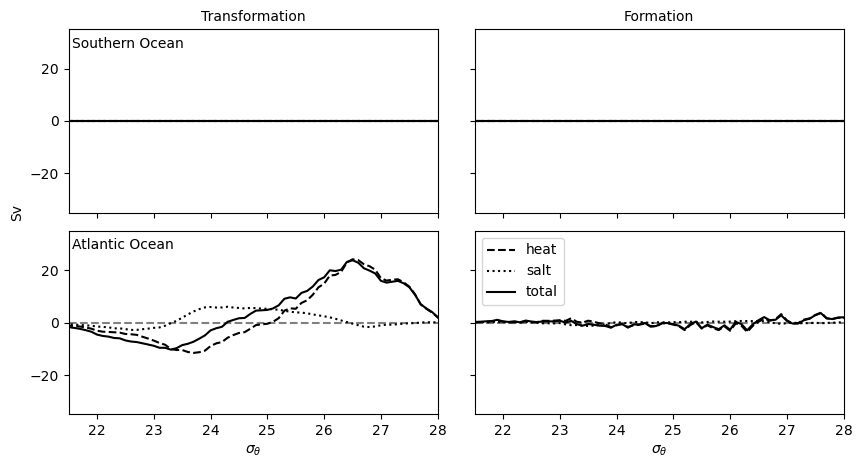

In [56]:
# Make plot layout
fig, axs = plt.subplots(2, 2, figsize=(10, 5), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
xlim = [21.5, 28]

# Loop through columns
for col, qty, title in zip(axs.T, ['tr', 'fm'], ['Transformation', 'Formation']):

    # Column formatting
    col[0].set_title(title)
    col[0].xaxis.set_ticklabels('')
    col[1].set_xlabel('$\\sigma_{\\theta}$')

    # Loop regions
    for ax, hs, region in zip(col, ['sh', 'nh'], [0, 5]):

        # Plot results
        for name, ls in zip(['heat', 'salt', 'total'], ['--', ':', '-']):
            ylim = [-35, 35]
            y = -wmtrfm[hs][qty][name][5, :]
            ax.plot(dclass[:-1], y, ls, color='k', label=name)

        # Formatting
        ax.plot(xlim, [0, 0], '--', color='gray', zorder=0)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        if qty == 'tr':
            ax.text(0.01, 0.9, regiondict[region], transform=ax.transAxes)
        else:
            ax.yaxis.set_ticklabels('')

# Final formatting
axs[1, 0].set_ylabel('Sv', y=1.1)
axs[1, 1].legend(loc=2)

***

### Residual Plots

Plot transformation/formation curves for SHSO and NHNA, comparing `py` and `f90` analyses

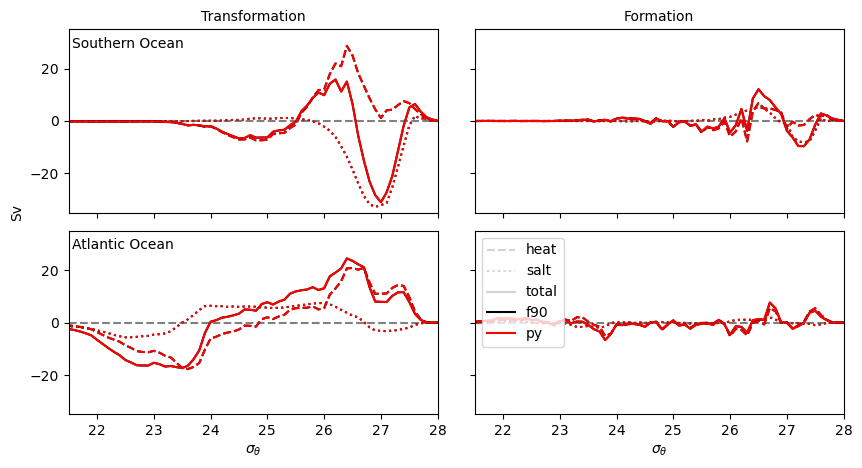

In [16]:
# Plot results
plot_results(residuals=False)

Plot residuals (`f90-py`)

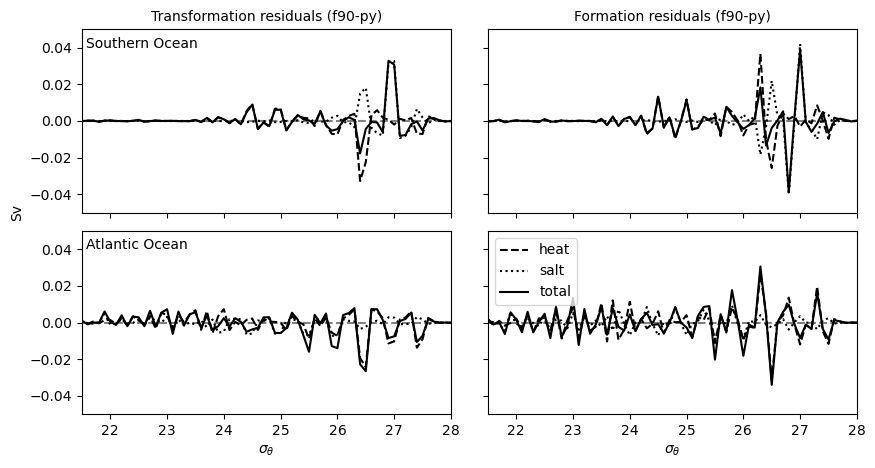

In [17]:
# Plot results
plot_results(residuals=True)